# Soft Matter
Investigating soft matter physics using Hooks law, PV = C and polygon patches. 

In [4]:
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse,Polygon
import matplotlib.tri as tri
import matplotlib.animation as animation
import numpy as np
import numpy.linalg as lag
from IPython.display import HTML

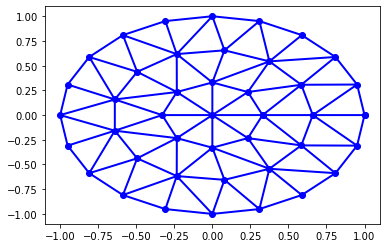

In [16]:
def n_gon_vert(n,centre=[0,0],radius=1,offset=0):
    thetas = np.linspace(0,2*np.pi,n+1)
    thetas += np.full(thetas.shape,offset)
    verts = np.array([np.cos(thetas),np.sin(thetas)])*radius
    return verts 
def construct_mesh(num_verts,radiuses,offsets=None):
    v = np.zeros((2,1))
    for i in range(len(num_verts)):
        v = np.append(v,n_gon_vert(num_verts[i],radius=radiuses[i]),axis=1)
    mesh = tri.Triangulation(v[0],v[1])
    return mesh
mesh = construct_mesh([20,13,8],[1,0.66,0.33])
fig,ax = plt.subplots()
tp = ax.triplot(mesh,"bo-",linewidth=2)

In [7]:
class Soft_Matter:
    def __init__(self,verticies=None):
        if not verticies:
            self.verticies = self.n_gon_vert(5)
        self.floor = 0

    def update(self):
        pass

    def n_gon_vert(self,n,centre=[0,0],radius=1,offset=0):
        thetas = np.linspace(0,2*np.pi,n+1)
        thetas += np.full(thetas.shape,offset)
        verts = np.array([np.cos(thetas),np.sin(thetas)])*radius
        return verts 
    
fig,ax = plt.subplots()
fig.set_size_inches(5,5)
fs = 2
ax.set(xlim=(-fs,fs),ylim=(-fs,fs))
verts = n_gon_vert(5)
plt.scatter(verts[0],verts[1])
pentagon = Polygon(verts.T,fill=False)
ax.add_patch(pentagon)

IndentationError: expected an indented block (<ipython-input-7-f9bcdc4b35b7>, line 10)

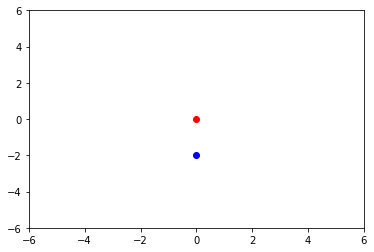

In [27]:
class Spring:
    def __init__(self,mass,k,position = [0,-2],velocity = [0,0],eq_length=1,d=2):
        self.m = mass
        self.k = k 
        self.d = d
        self.pivot = np.zeros(self.d)
        self.r = np.array(position)
        self.r_n_1 = np.array(position)
        self.v = np.array(velocity)
        self.eq_length = eq_length
    def force(self):
        r_hat = (self.r-self.pivot)/lag.norm(self.r-self.pivot)
        extension = lag.norm(self.r)-self.eq_length
        return -self.k*extension*r_hat

    def update(self,dt):
        """"Obsolete method as non energy conserving nature of Euler method
        means that trajectory has heavy dependance on size of dt."""
        new_v = self.v + dt*self.force()/self.m
        new_r = self.r + dt*self.v
        self.v = new_v
        self.r = new_r
    def update_verlet(self,dt):
        ##uses the verlet integration method to conserve velocities
        new_r = self.r*2 -self.r_n_1+dt**2*self.force()/self.m
        self.r_n_1 = self.r
        self.r = new_r 

    def generate_movement_data(self,T,dt):
        r_data = np.zeros((T+1,self.d))
        v_data = np.zeros((T+1,self.d))
        r_data[0,:] = self.r
        v_data[0,:] = self.v
        for i in range(T):
            self.update_verlet(dt)
            r_data[i,:] = self.r
            v_data[i,:] = self.v
        return r_data,v_data

    def animate_movement(self,T,dt):
        fig,ax = plt.subplots()
        s = 4
        ax.set(xlim = (-s*self.eq_length,s*self.eq_length),ylim=(-s*self.eq_length,s*self.eq_length))
        r_data,v_data = self.generate_movement_data(T,dt)
        p = ax.scatter(self.pivot[0],self.pivot[1],c="r")
        ball = ax.scatter(r_data[0,0],r_data[0,1],c="b")
        def update(i):
            ball.set_offsets(r_data[i,:])
        anim = animation.FuncAnimation(fig,update,T)
        return anim

spring = Spring(1,1,eq_length=1.5)
anim = spring.animate_movement(65,1)
HTML(anim.to_jshtml())


## Verlet Integrators 
The Verlet integrators are symplectic integratotrs - they conserve the total energy of the system. We can implement this bypassing velocities using $$x_{n+1}=2x_n-x_{n-1}+a_n dt^2$$ or using the Velocity Verlet Integrator $$v_{n+1} =v_n +\frac{a_n+a_{n+1}}{2} dt$$ $$x_{n+1} = x_n +v_ndt +\frac{1}{2}a_n dt^2 $$

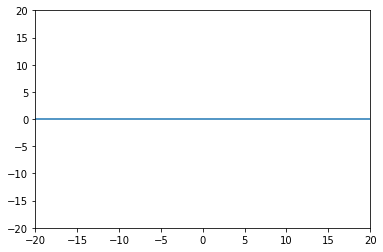

In [26]:
#TODO implement velocity verlet algorithm to allow for non 0 initial velocities

class Gravity_Object:
    g = 9.8
    def __init__(self,mass,position,floor_height,v,R = 0.1,cr=0.1):
        self.r = np.array(position)
        self.r_n_1 = np.array(position)
        self.v = np.array(v)
        self.m = mass
        self.R = R
        self.floor = floor_height
        self.cr = cr  ## coefficient of restitution

    def a(self):
        return np.array([0,-self.g])
    def impulse(self,dt):
        return np.array([0,-self.m*self.v[1]*(1+self.cr)/dt])

    def update(self,dt):
        c = self.collision()
        if c:
            a_n = self.impulse(dt)/self.m
            new_v = self.v 
            new_v[1] = -self.v[1]*self.cr
            self.v= new_v
            new_r = self.r + dt*self.v + 0.5*a_n*dt**2
            self.r = new_r
        else:
            new_r = self.r + dt*self.v + 0.5*self.a()*dt**2
            new_v = self.v + dt*(self.a()+self.a())/2
            self.r = new_r
            self.v = new_v

    def collision(self):
        if self.r[1] <self.floor+self.R:
            return True
        else:
            return False
    
    def generate_movement_data(self,T,dt):
        r_data = np.zeros((T+1,2))
        r_data[0,:] = self.r
        for i in range(T):
            self.update(dt)
            r_data[i,:] = self.r
        return r_data

    def animate_movement(self,T,dt):
        fig,ax = plt.subplots()
        s = 4
        self.frame_size = lag.norm(self.r)*s
        ax.set(xlim = (-self.frame_size,self.frame_size),ylim=(-self.frame_size,self.frame_size))
        r_data = self.generate_movement_data(T,dt)
        ball = ax.scatter(r_data[0,0],r_data[0,1],c="b")
        floor  = ax.plot([-self.frame_size,self.frame_size],[self.floor,self.floor])
        def update(i):
            ball.set_offsets(r_data[i,:])
        anim = animation.FuncAnimation(fig,update,T)
        return anim
go = Gravity_Object(1,[0,5],0,[5,-5],R=1,cr=0.3)
anim = go.animate_movement(100,0.1)
HTML(anim.to_jshtml())

# 